# Time Series Model

In [1]:
import pandas as pd
import numpy as np
import holidays
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import importlib

Monterrey = pd.read_csv("Files/Datos_22_24_CENTRO_limpios.csv", parse_dates=[0], index_col = "date")
daily_Monterrey = Monterrey.resample('D').mean()

## Functions

In [2]:
# Directorio de archivos
import sys
sys.path.append("Functions")

import Feature_Engineering
import Model

importlib.reload(Feature_Engineering)
importlib.reload(Model)

<module 'Model' from 'c:\\Users\\José Antonio\\Documents\\TEC\\Python\\Multivariados\\Functions\\Model.py'>

### Feature Engineering

In [3]:
from Feature_Engineering import add_holiday_feature
from Feature_Engineering import add_weekend_feature
from Feature_Engineering import add_cyclic_feature

### Model

In [4]:
from Model import apply_lag
from Model import scale_dataframe
from Model import split_data
from Model import time_series_lstm_cv
from Model import plot_time_series_with_predictions
from Model import plot_mse_per_fold

## Data lecture and feature engineering

In [5]:
daily_Monterrey, festivos_df = add_holiday_feature(daily_Monterrey, 2022, 2024, country='Mexico')
daily_Monterrey = add_weekend_feature(daily_Monterrey)

## PM10

### Feature Engineering

In [6]:
daily_Monterrey_pm10 = add_cyclic_feature(daily_Monterrey, "2022-01-03", 37, column_name="is_37_day_cycle")

### Desfase de un día de variables

In [7]:
daily_Monterrey_pm10 = apply_lag(daily_Monterrey_pm10, 1, ["PM10"])

### Scaling

Scaler_X: Es para variables que se eligieron (De las independientes)
Scaler_y: Es para la que se quiere predecir (Dependiente)

In [8]:
X_scaled, y_scaled, scaler_X, scaler_y = scale_dataframe(daily_Monterrey_pm10, list(daily_Monterrey_pm10.columns)[4:], "PM10", feature_range=(0, 1), return_scalers=True)

### Cross-Validation with LSTM (Forward Chaining with train, validations and test sets)

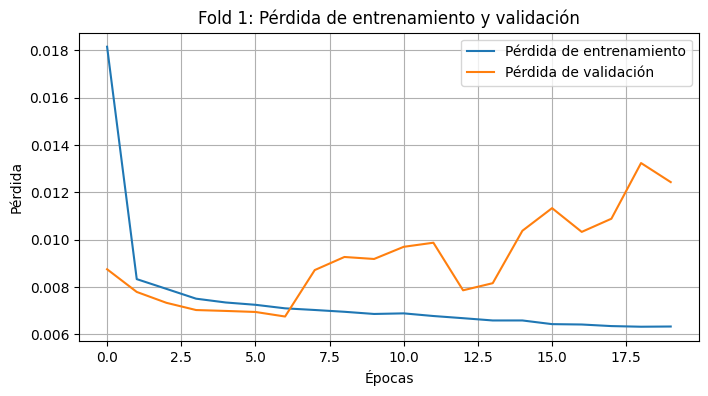

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


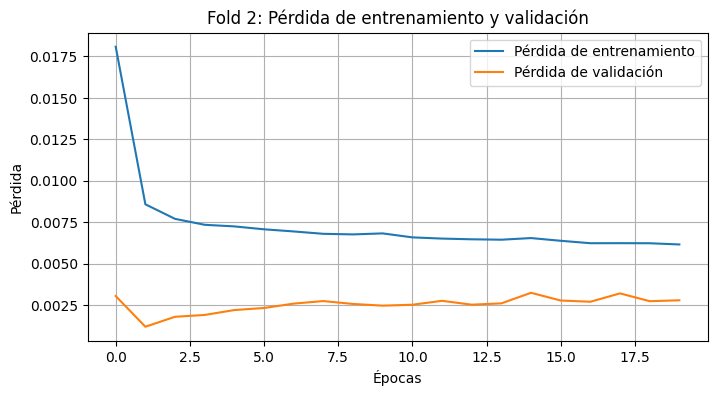

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


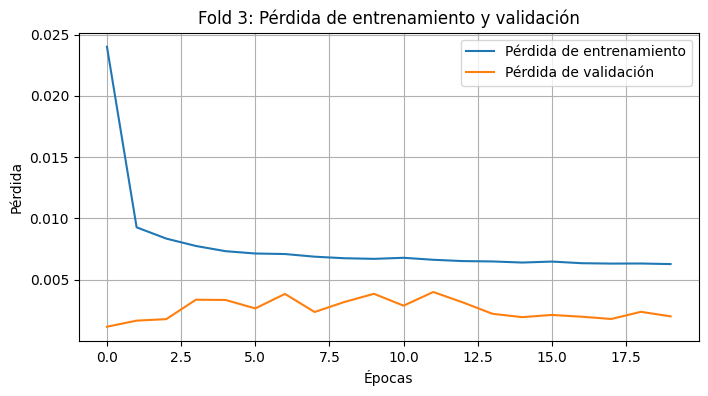

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


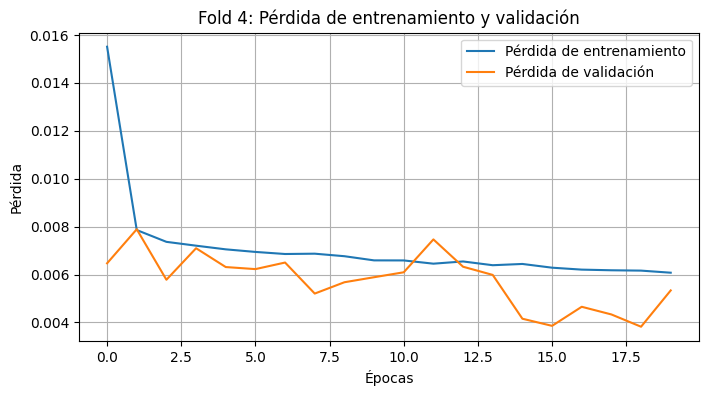

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


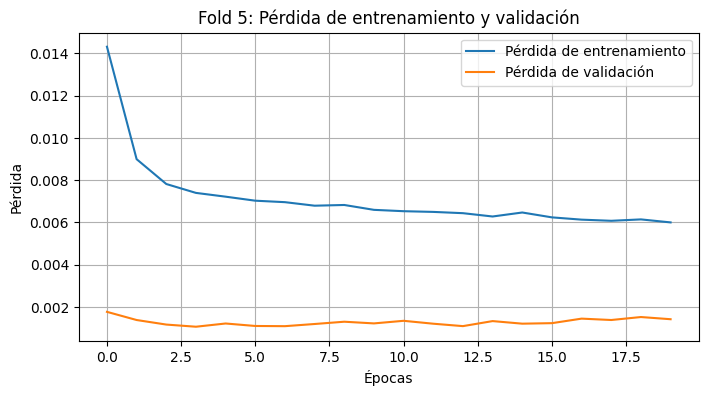

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [9]:
historical_predictions, historical_real_values, cutoff_dates, mse_per_fold = time_series_lstm_cv(
    X_scaled=X_scaled,
    y_scaled=y_scaled,
    scaler_y=scaler_y,
    splits=5, # Número de folds
    test_size=7, # Número de observaciones para testeo
    validation_size=7, # Número de observaciones para validación
    daily_index=daily_Monterrey.index # Fechas del dataframe
)

### Results from each fold in test data

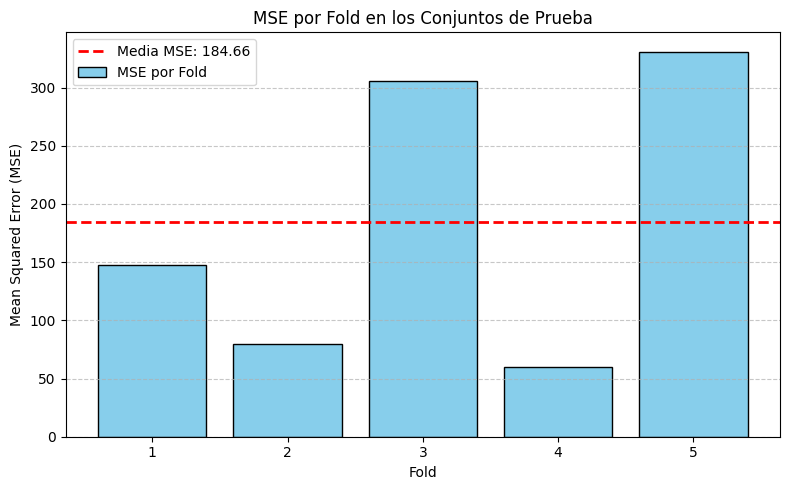

In [10]:
plot_mse_per_fold(mse_per_fold)

### Time series predictions

In [11]:
plot_time_series_with_predictions(
    historical_real_values = historical_real_values,
    historical_predictions = historical_predictions,
    cutoff_dates = cutoff_dates,
    historical_series = daily_Monterrey_pm10['PM10']
)

## SO2

### Feature Engineering

In [12]:
daily_Monterrey_so2 = add_cyclic_feature(daily_Monterrey, "2022-01-01", 94, column_name = "is_94_day_cycle")

### Desfase de un día de variables

In [13]:
daily_Monterrey_so2 = apply_lag(daily_Monterrey_so2, 1, ["SO2"])

### Scaling

Scaler_X: Es para variables que se eligieron (De las independientes)
Scaler_y: Es para la que se quiere predecir (Dependiente)

In [14]:
X_scaled, y_scaled, scaler_X, scaler_y = scale_dataframe(daily_Monterrey_so2, list(daily_Monterrey_so2.columns)[4:], "SO2", feature_range=(0, 1), return_scalers=True)

### Cross-Validation with LSTM (Forward Chaining with train, validations and test sets)

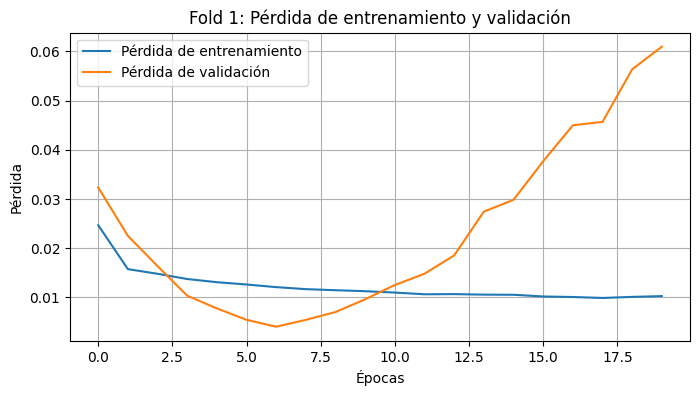

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


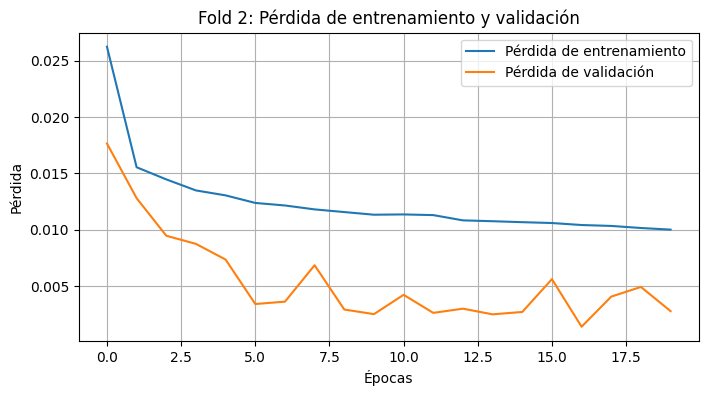

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


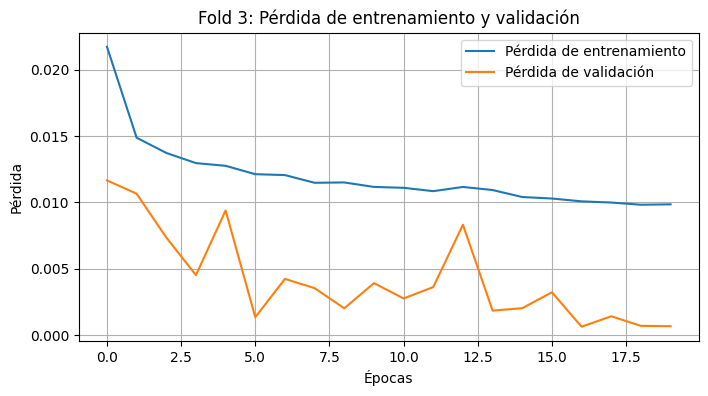

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


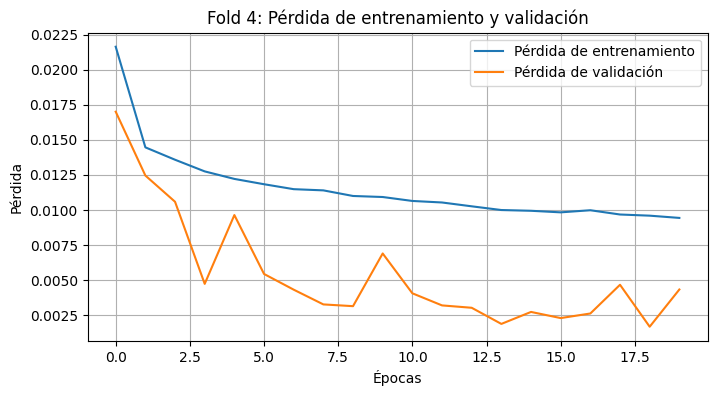

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


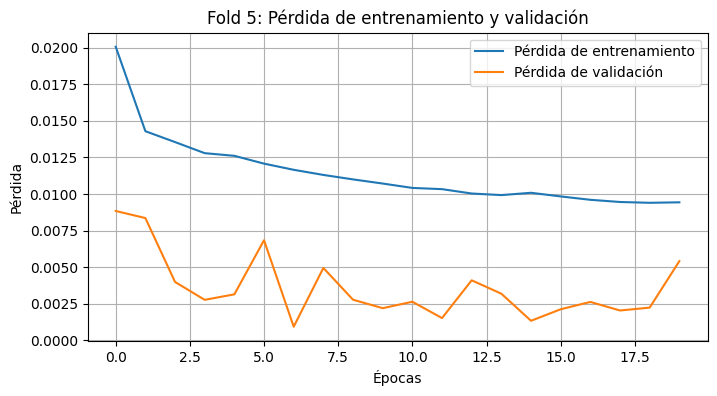

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [15]:
historical_predictions, historical_real_values, cutoff_dates, mse_per_fold = time_series_lstm_cv(
    X_scaled=X_scaled,
    y_scaled=y_scaled,
    scaler_y=scaler_y,
    splits=5, # Número de folds
    test_size=7, # Número de observaciones para testeo
    validation_size=7, # Número de observaciones para validación
    daily_index=daily_Monterrey.index # Fechas del dataframe
)

### Results from each fold in test data

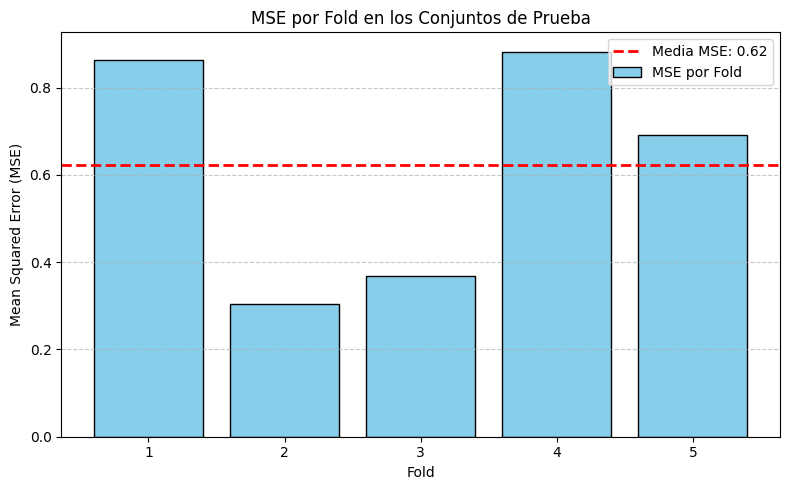

In [16]:
plot_mse_per_fold(mse_per_fold)

### Time series predictions

In [17]:
plot_time_series_with_predictions(
    historical_real_values = historical_real_values,
    historical_predictions = historical_predictions,
    cutoff_dates = cutoff_dates,
    historical_series = daily_Monterrey_so2['SO2']
)

## CO

### Feature Engineering

In [18]:
daily_Monterrey_co = add_cyclic_feature(daily_Monterrey, "2022-01-01", 135, column_name="is_135_day_cycle")

### Desfase de un día de variables

In [19]:
daily_Monterrey_co = apply_lag(daily_Monterrey_co, 1, ["CO"])

### Scaling

Scaler_X: Es para variables que se eligieron (De las independientes)
Scaler_y: Es para la que se quiere predecir (Dependiente)

In [20]:
X_scaled, y_scaled, scaler_X, scaler_y = scale_dataframe(daily_Monterrey_co, list(daily_Monterrey_co.columns)[4:], "CO", feature_range=(0, 1), return_scalers=True)

### Cross-Validation with LSTM (Forward Chaining with train, validations and test sets)

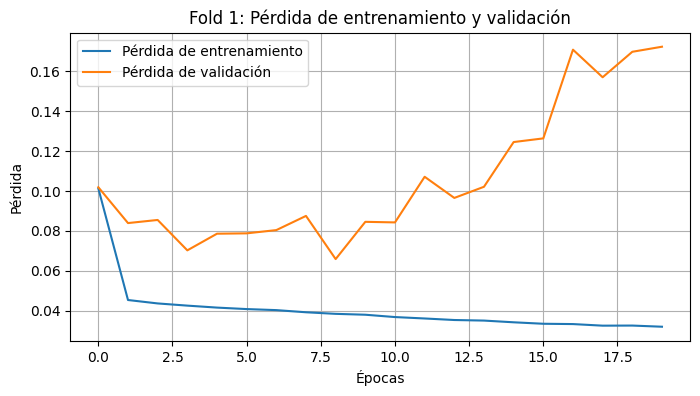

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


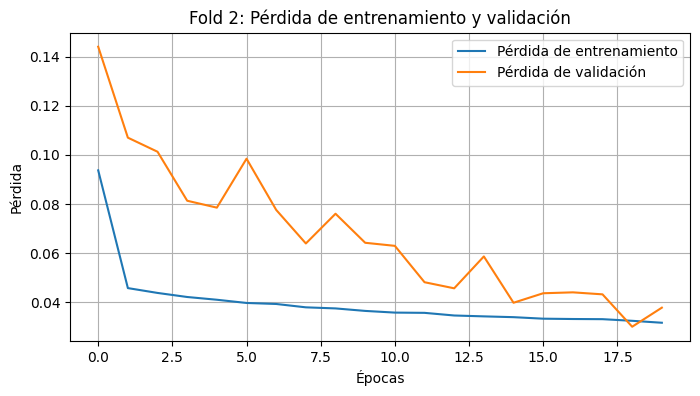

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


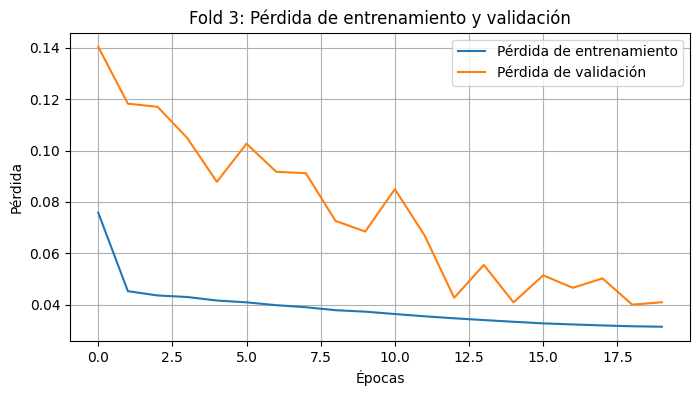

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


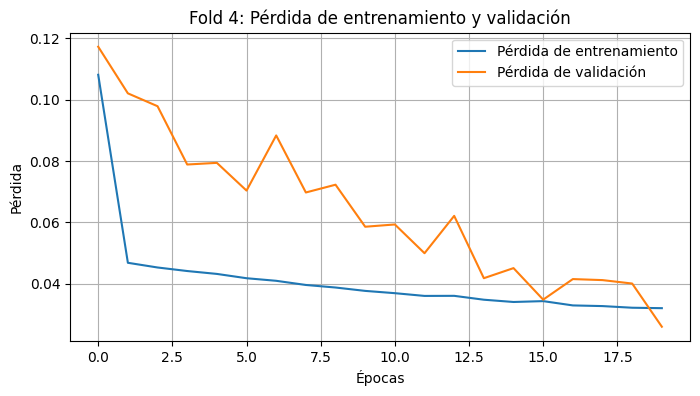

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


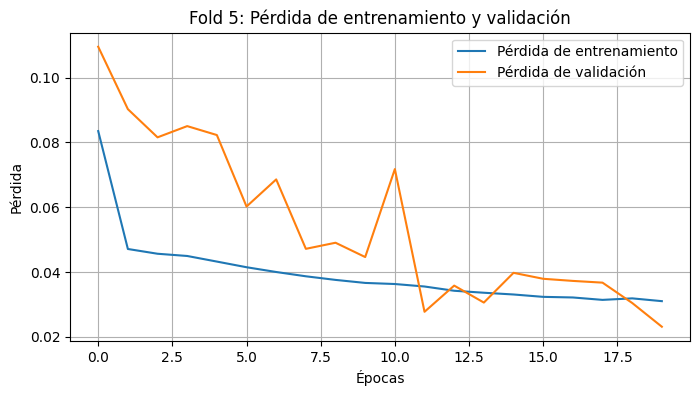

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [21]:
historical_predictions, historical_real_values, cutoff_dates, mse_per_fold = time_series_lstm_cv(
    X_scaled=X_scaled,
    y_scaled=y_scaled,
    scaler_y=scaler_y,
    splits=5, # Número de folds
    test_size=7, # Número de observaciones para testeo
    validation_size=7, # Número de observaciones para validación
    daily_index=daily_Monterrey.index # Fechas del dataframe
)

### Results from each fold in test data

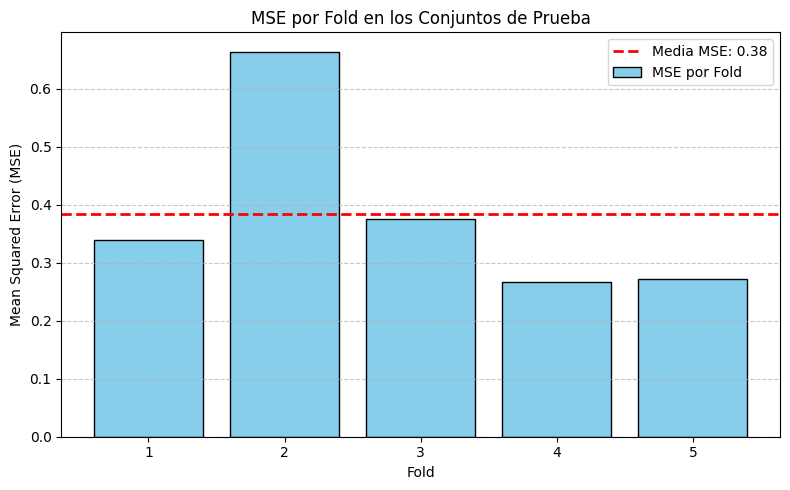

In [22]:
plot_mse_per_fold(mse_per_fold)

### Time series predictions

In [23]:
plot_time_series_with_predictions(
    historical_real_values = historical_real_values,
    historical_predictions = historical_predictions,
    cutoff_dates = cutoff_dates,
    historical_series = daily_Monterrey_co['CO']
)

## NOX

### Feature Engineering

In [24]:
daily_Monterrey_NOX = add_cyclic_feature(daily_Monterrey, "2022-01-01", 7, column_name="is_7_day_cycle")

### Desfase de un día de variables

In [25]:
daily_Monterrey_NOX = apply_lag(daily_Monterrey_NOX, 1, ["NOX"])

### Scaling

Scaler_X: Es para variables que se eligieron (De las independientes)
Scaler_y: Es para la que se quiere predecir (Dependiente)

In [26]:
X_scaled, y_scaled, scaler_X, scaler_y = scale_dataframe(daily_Monterrey_NOX, list(daily_Monterrey_NOX.columns)[4:], "NOX", feature_range=(0, 1), return_scalers=True)

### Cross-Validation with LSTM (Forward Chaining with train, validations and test sets)

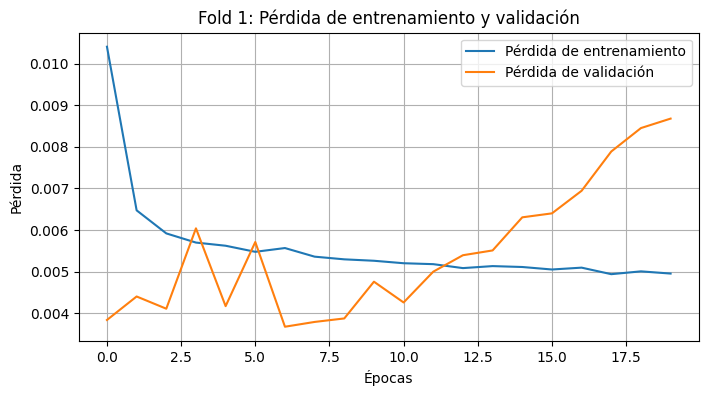

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


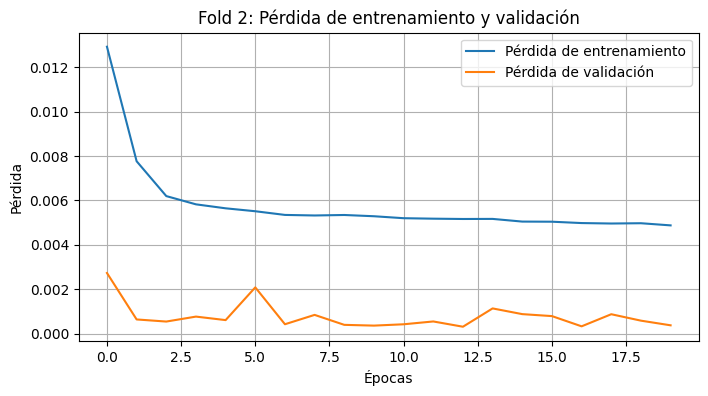

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


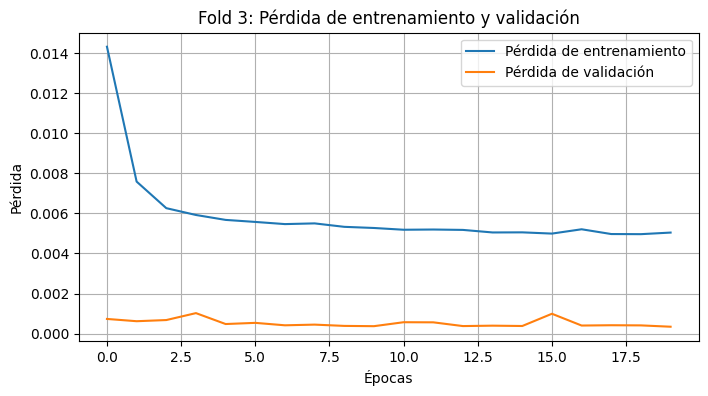

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


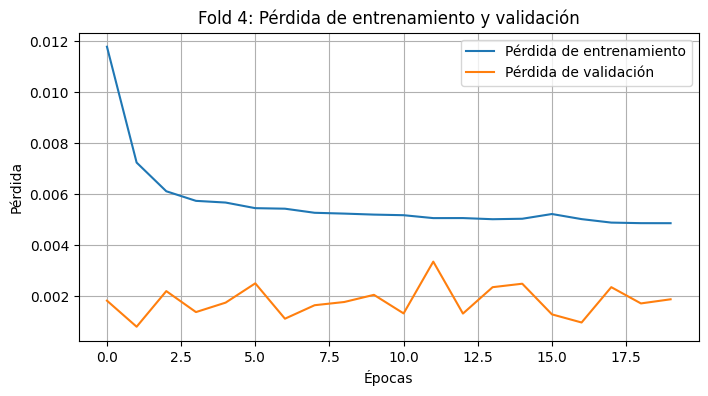

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


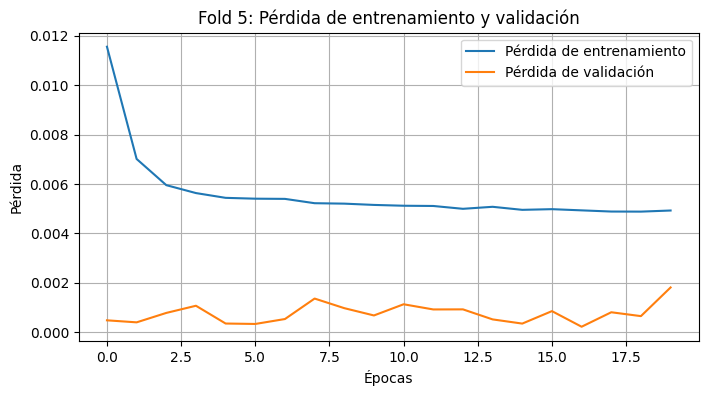

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [27]:
historical_predictions, historical_real_values, cutoff_dates, mse_per_fold = time_series_lstm_cv(
    X_scaled=X_scaled,
    y_scaled=y_scaled,
    scaler_y=scaler_y,
    splits=5, # Número de folds
    test_size=7, # Número de observaciones para testeo
    validation_size=7, # Número de observaciones para validación
    daily_index=daily_Monterrey.index # Fechas del dataframe
)

### Results from each fold in test data

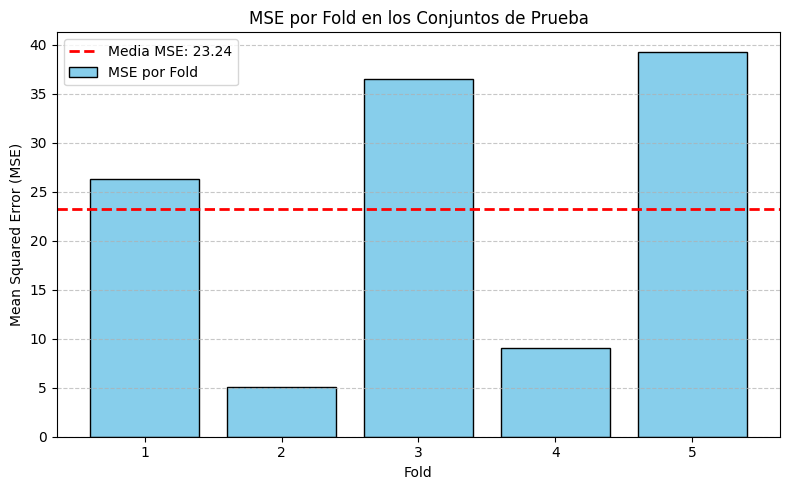

In [28]:
plot_mse_per_fold(mse_per_fold)

### Time series predictions

In [29]:
plot_time_series_with_predictions(
    historical_real_values = historical_real_values,
    historical_predictions = historical_predictions,
    cutoff_dates = cutoff_dates,
    historical_series = daily_Monterrey_NOX['NOX']
)